# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [5]:
import random
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
class Agent:
    
    
    def __init__(self, env, gamma, buffer_size, batch_size, learning_rate=5e-4, load_weights=None, train_mode=True):
        
        seed = 110
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # General
        env_info = env.reset(train_mode=train_mode)[brain_name]
        state = env_info.vector_observations[0]
        self.n_states = len(state)
        self.n_actions = brain.vector_action_space_size
        self.train_mode = train_mode
        
        # Learning
        self.gamma = gamma
        
        # Q-networks
        self.learning_rate = learning_rate
        self.qnetwork = QNetwork(self.n_states, self.n_actions, seed).to(self.device)
        self.target_qnetwork = QNetwork(self.n_states, self.n_actions, seed).to(self.device)
        if load_weights is not None:
            self.target_qnetwork.load_state_dict(torch.load(load_weights))
            self.qnetwork.load_state_dict(torch.load(load_weights))
        else:
            self.target_qnetwork.load_state_dict(self.qnetwork.state_dict())
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=learning_rate)
        
        # Experience replay
        self.memory = deque(maxlen=buffer_size)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experience = namedtuple('experience', ['state', 'action', 'reward', 'next_state', 'done'])
        
        
        
    
    
    
    def update_target_qnetwork(self):
        """
        Copy the weights of the main network to the target network.
        """
        #self.target_qnetwork.set_weights(self.qnetwork.get_weights())
        # alternative solution is to use soft-update:
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        tau = 1e-3
        for target_param, local_param in zip(self.target_qnetwork.parameters(), self.qnetwork.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
    
    
    def update_main_qnetwork(self):
        """
        Updates the main q-network
        """
        # sample
        minibatch = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in minibatch if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in minibatch if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in minibatch if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in minibatch if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in minibatch if e is not None]).astype(np.uint8)).float().to(self.device)
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    
    
    def take_action(self, state, epsilon):
        """
        The greedy action procedure.
        We use the main network to find the action.
        """
        if np.random.rand() <= epsilon:
            action = torch.tensor([np.random.randint(self.n_actions)], device=self.device, dtype=torch.long)
        else:
            # predict using main network
            with torch.no_grad():
                s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                action = self.qnetwork(s).max(1)[1].view(1, 1)
        
        return action.item()
    
    
    
    def add_experience(self, state, action, reward, next_state, done):
        """
        Add the latest experience tuple
        """
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)

In [12]:
def dqn(env, agent, n_episodes = 1800, min_epsilon = 0.05, epsilon_decay = 0.995, 
        t_max = 10, epsilon = 1.0, update_target_frequency = 10, 
        update_main_frequency = 2):
    
    TARGET_SCORE = 15.0
    epsilon = 1.0

    # counts the total steps (we use it to see when to train the main qnetwork and when to copy main to target.)
    iteration = 0
    
    # To store scores
    scores = []
    scores_window = deque(maxlen=100)

    for episode in range(1, n_episodes+1):

        score = 0
        env_info = env.reset(train_mode=agent.train_mode)[brain_name]    # reset the environment
        s1 = env_info.vector_observations[0]  
        
        # update epsilon value
        epsilon = max(min_epsilon, epsilon*epsilon_decay)

        while True:

            # take action when in state S
            action = agent.take_action(s1, epsilon)

            # take next step
            env_info = env.step(action)[brain_name]
            s2 = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            # update score in current episode
            score += reward
            
            # store experinece tuple (s1, a, r, s2, done) to the memory
            agent.add_experience(s1, action, reward, s2, done)
            
            # update main q-network
            if iteration % update_main_frequency == 0:
                if len(agent.memory) >= agent.batch_size:
                    agent.update_main_qnetwork()

            # update target q-network
            if iteration % update_target_frequency == 0:
                agent.update_target_qnetwork()

            # update counter
            iteration += 1 

            s1 = s2

            if done:
                break
                
        scores.append(score)
        scores_window.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="\r")
        if episode % 100 == 0:
            print(f"Episode={episode:03}\tAverage Score={np.mean(scores_window)}")
          
        if np.mean(scores_window) >= TARGET_SCORE:
            print(f"Agent reached target score in {episode} episodes! (Avg. Score = {np.mean(scores_window)})")
            # save main qnetwork
            torch.save(agent.qnetwork.state_dict(), 'checkpoint01.pth')
            break
    
    return scores

In [13]:
agent = Agent(env, gamma=0.99, buffer_size=100000, batch_size=64, learning_rate=5e-4, train_mode=True)

In [14]:
scores = dqn(env, agent, n_episodes = 1800, min_epsilon=0.01, epsilon_decay = 0.995, 
             t_max = 1000, update_target_frequency=4, update_main_frequency = 4)

Episode=100	Average Score=1.199
Episode=200	Average Score=5.788
Episode=300	Average Score=8.770
Episode=400	Average Score=10.000
Episode=500	Average Score=13.255
Episode=600	Average Score=13.955
Agent reached target score in 666 episodes! (Avg. Score = 15.06)


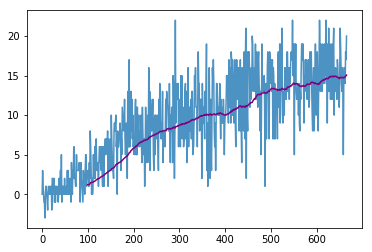

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(scores, alpha=0.8)
plt.plot(pd.Series(scores).rolling(100).mean(), color='purple', linestyle='-')
plt.show()